#### Importing all packages required for the different functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import seaborn as sns
from scipy import signal
import pandas as pd
import bruges as b

from ipywidgets import interact, IntSlider, FloatSlider, interact_manual
# from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, interact_manual
from IPython.display import display, HTML
# from matplotlib.gridspec import GridSpec

%matplotlib inline

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font size="6" color="red">The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')

# AVO and AVO Analysis Basics

This walktrough assumes some introductory knowledge of the seismic experiement and zero-incident/offset seismic concepts. It attemps to expands upon that concept by explaining, with examples, the significance of amplitude changes at incident angles greater than zero. This topic (as well as the more simple zero-incident case) is explained simply but succinctly by Matt Hall of agilegeoscience here: https://agilescientific.com/blog/2011/6/6/what-is-avo.html

The basics, however are as follows: "The basic physics behind AVO analysis is that the strength of a reflection does not only depend on the acoustic impedance—it also depends on the angle of incidence."$^{[1]}$  

Analysis of AVO, or amplitude variation with offset, seeks to extract rock parameters (velocity, density, etc.) by analyzing seismic amplitude as a function of offset, or more correctly as a function of reflection angle.

The reflection coefficient for plane elastic waves as a function of reflection angle at a single interface is described by the complicated Zoeppritz equations (Zoeppritz 1919). For the analysis of P-wave reflections, a well-known approximation is given by Aki and Richards (1980), assuming weak layer contrasts.$^{[2]}$ These equations, their meaning, and their importance will be discussed below.

${[1]}$ https://agilescientific.com/blog/2011/6/6/what-is-avo.html  
${[2]}$ Avseth, Per; Mukerji, Tapan; Mavko, Gary. Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk (Kindle Location 3990). Cambridge University Press. Kindle Edition. 

### Knott-Zoeppritz matrix representation (from Castanga and Backus 1993)

Below is the matrix representation of the Knott-Zoeppritz equations such that $Q = P^{-1} R$

The Zoepprittz equations describe how energy is partitioned at an interface. While accurate, these equations do not provide a very intuitive physical understanding of how reflection varies with rock properties. There are several approximations to the Zoeppritz equations which attempt to show which physical properties of rocks control reflection varaitions most directly. These will be introduced below the Zoeppritz equations.

##### From Castagna and Backus 1993: 

For an interface between two infinite elastic half-spaces, there are sixteen reflection and transmission coefficients. In the Aki and Richards notation, the coefficients are represented by two letters (e.g. $\grave{P}\acute{S}$). The first letter indicates the type of incident wave and the second letter represents the type of derived wave. The acute acent indicates an upgoing wave while a downgoing wave has a grave accent. Thus, $\grave{P}\acute{S}$ is the downgoing P-wave to the upgoing S-wave coefficient. With this notation, the scattering matrix is:
    
  $$ 
   Q=
  \left[ {\begin{array}{cccc}
   \grave{P}\acute{P} & \grave{S}\acute{P} & \acute{P}\acute{P} & \acute{S}\acute{P} \\
   \grave{P}\acute{S} & \grave{S}\acute{S} & \acute{P}\acute{S} & \acute{S}\acute{S} \\
   \grave{P}\grave{P} & \grave{S}\grave{P} & \acute{P}\grave{P} & \acute{S}\grave{P} \\   
   \grave{P}\grave{S} & \grave{S}\grave{S} & \acute{P}\grave{S} & \acute{S}\grave{S} \\       
  \end{array} } \right]
     = P^{-1}R
  $$
  
  $$Where:$$ 

 $$ 
   P= \left[ {\begin{array}{cccc}
   -sin\ \theta_1 & -cos\ \phi_1 & sin\ \theta_2 & cos\ \phi_2 \\
   cos\ \theta_1 & -sin\ \phi_1 & cos\ \theta_2 & -sin\ \phi_2 \\
   2 \rho_1 V_{s1} sin\ \phi_1 cos\ \theta_1 & \rho_1 V_{s1}(1 - 2sin^2 \phi_1) & 2\rho_2 V_{s2} sin\ \phi_2 cos\ \theta_2 & \rho_2 V_{s2} (1-2sin^2\ \phi_2)\\ 
   -\rho V_{p1} (1-2sin^2\ \phi_1) & \rho_1 V_{s1} sin\ 2\phi_1 & \rho_2 V_{p2}(1-2 sin^2\ \phi_2) & -\rho_2V_{p2} sin2\ \phi_2
  \end{array} } \right]   
  $$
  
  $$and$$
  
  $$
     R=
  \left[ {\begin{array}{cccc}
   sin\ \theta_1 & cos\ \phi_1 & -sin\ \theta_2 & -cos\ \phi_2 \\
   cos\ \theta_1 & -sin\ \phi_1 & cos\ \theta_2 & -sin\ \phi_2 \\
   2 \rho_1 V_{s1} sin\ \phi_1 cos\ \theta_1 & \rho_1 V_{s1}(1 - 2sin^2 \phi_1) & 2\rho_2 V_{s2} sin\ \phi_2 cos\ \theta_2 & \rho_2 V_{s2} (1-2sin^2\ \phi_2)\\ 
   \rho V_{p1} (1-2sin^2\ \phi_1) & -\rho_1 V_{s1} sin\ 2\phi_1 & -\rho_2 V_{p2}(1-2 sin^2\ \phi_2) & \rho_2V_{p2} sin2\ \phi_2
  \end{array} } \right] 
  $$

Parameters are defined here

Format for vp,vs,rho is:  
$V_p,V_s,\rho = ([[V_p\ Layer\ 1, V_p\ Layer\ 2],[V_s\ Layer\ 1, V_s\ Layer\ 2],[\rho\ Layer\ 1, \rho\ Layer\ 2]])$


In [3]:
theta = 20
vp,vs,rho = ([[2468,2600],[1006,1700],[2250,1850]])
#vp,vs,rho = ([[2468,2600],[1006,1700],[2250,1850]]) #defaults

vs1=vs[0]; vs2=vs[1]    
vp1=vp[0]; vp2 = vp[1]    
rho1=rho[0]; rho2=rho[1] 
#theta1 = range(91)

Zoeppritz scattering matrix defined below:

In [4]:
def zoeppritz(vp,vs,rho,theta):

    theta1 = np.radians(theta).astype(complex)
    vs1=vs[0]; vs2=vs[1]    
    vp1=vp[0]; vp2 = vp[1]    
    rho1=rho[0]; rho2=rho[1]
    p = np.sin(theta1) / vp1 # ray parameter p
    theta2 = np.arcsin(p*vp2)
    phi1= np.arcsin(p*vs1)
    phi2 = np.arcsin(p*vs2)

    P = np.array([[-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)],
              [np.cos(theta1), -np.sin(theta1), np.cos(theta2), -np.sin(phi2)], 
              [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2), 
               2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
              [-rho1*vp1*(1-2*np.sin(theta1)**2), rho1*vs1*np.sin(2*phi1),
               rho2*vp2*(1-2*np.sin(phi2)**2),-rho2*vs2*np.sin(2*phi2)]])

    R = np.array([[np.sin(theta1), np.cos(phi1), -np.sin(theta2), -np.cos(phi2)],
              [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
              [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2),
               2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
              [rho1*vp1*(1-2*np.sin(theta1)**2), -rho1*vs1*np.sin(2*phi1),
               -rho2*vp2*(1-2*np.sin(phi2)**2),rho2*vs2*np.sin(2*phi2)]])

    Q = np.linalg.inv(P)*R
    
    return Q

# Function for sliders
def zoe_sliders(vp1=2468, vp2=2600, vs1=1006, vs2=1700, rho1=2250, rho2=1850, theta=20):
    vp = [vp1, vp2]
    vs = [vs1, vs2]
    rho = [rho1, rho2]
    scattering_matrix = pd.DataFrame(np.real(zoeppritz(vp,vs,rho,theta)))
    
    print('The real components of the scattering matrix for a wave incident at ' 
      + str(theta) + ' degrees: ')
    display(scattering_matrix)

In [5]:
interact(zoe_sliders,
         vp1=IntSlider(min=1000, max=4500, value=1500, ),
         vp2=IntSlider(min=1000, max=4500, value=2600),
         vs1=IntSlider(min=400, max=3500, value=1006),
         vs2=IntSlider(min=400, max=3500, value=1700),
         rho1=IntSlider(min=1650, max=2870, value=2250),
         rho2=IntSlider(min=1650, max=2870, value=1850),
         theta=IntSlider(min=0, max=89, value=20)
        )

interactive(children=(IntSlider(value=1500, description='vp1', max=4500, min=1000), IntSlider(value=2600, desc…

<function __main__.zoe_sliders>


Recall:
  $
   Q=
  \left[ {\begin{array}{cccc}
   \grave{P}\acute{P} & \grave{S}\acute{P} & \acute{P}\acute{P} & \acute{S}\acute{P} \\
   \grave{P}\acute{S} & \grave{S}\acute{S} & \acute{P}\acute{S} & \acute{S}\acute{S} \\
   \grave{P}\grave{P} & \grave{S}\grave{P} & \acute{P}\grave{P} & \acute{S}\grave{P} \\   
   \grave{P}\grave{S} & \grave{S}\grave{S} & \acute{P}\grave{S} & \acute{S}\grave{S} \\       
  \end{array} } \right]
     = P^{-1}R
  $

### Zoeppritz Rpp and Rps from Aki Richards, 1980 derivation
#### Restated in Lu et al., 2015 *Joint PP and PS AVA seismic inverson using the exact Zoeppritz equations*

These are linear represetnations of the Zoepprittz equations for $\grave{P}\acute{P}$ and $\grave{P}\acute{S}$ waves. This allows for an array to be passed to a zoeppritz solver, rather than a single value for theta which we must then iterate over.

https://doi.org/10.1190/geo2014-0490.1

$$R_{pp} = \left[\left(b\frac{cos\ \theta_1}{V_{p1}} - c \frac{cos\ \theta_2}{V_{p2}}\right)F - \left(a + d \frac{cos\ \theta_1}{V_{p1}} \frac{cos\ \phi_2}{V_{s2}}\right)Hp^2\right]/D$$

$and$

$$R_{ps} = -2 \frac{cos\ \theta_1}{V_{p1}}\left(ab + cd\frac{cos\ \theta_2}{V_{p2}}\frac{cos\ \phi_2}{V_{s2}}\right)pV_{p1}/(V_{s1}D)$$

$Where$

$p\ \text{is the ray parameter, which is constant for all layers such that }p = sin\ \theta_1/V_{p1} = sin\ \theta_2/V_{p2} = sin\ \phi_1/V_{s1} = sin\ \phi_2/V_{s2}$

$a = \rho_2(1-2V_{s2}^2 p^2) - \rho_1(1-2V_{s1}^2 p^2)\\ 
b = \rho_2(1-2V_{s2}^2 p^2) + 2\rho_1 V_{s1}^2 p^2\\
c = \rho_1(1-2V_{s1}^2 p^2) + 2\rho_2V_{s2}^2p^2\\
d = 2(\rho_2 V_{s2}^2 - \rho_1 V_{s1}^2)$

$and$

$E = b\frac{cos\ \theta_1}{V_{p1}} + c\frac{cos\ \theta_2}{V_{p2}}\\
F = b\frac{cos\ \phi_1}{V_{s1}} + c\frac{cos\ \phi_2}{V_{s2}}\\
G = a -d \frac{cos\ \theta_1}{V_{p1}}\frac{cos\ \phi_2}{V_{s2}}\\
H = a -d \frac{cos\ \theta_2}{V_{p2}} \frac{cos\ \phi_1}{V_{s1}}\\
D = EF + GHp^2$



In [6]:
#Full Zoeppritz Rpp and Rps from Aki and Richards 1980 derivation
def zoeRppRps(vp,vs,rho,thetaMax):    
    theta1 = np.radians(np.arange(thetaMax)).astype(complex)
    p = np.sin(theta1) / vp[0]  # Ray parameter
    theta2 = np.arcsin(p * vp[1])
    phi1 = np.arcsin(p * vs[0])  # Reflected S
    phi2 = np.arcsin(p * vs[1])  # Transmitted S

    a = rho[1] * (1 - 2 * np.sin(phi2)**2.) - rho[0] * (1 - 2 * np.sin(phi1)**2.)
    b = rho[1] * (1 - 2 * np.sin(phi2)**2.) + 2 * rho[0] * np.sin(phi1)**2.
    c = rho[0] * (1 - 2 * np.sin(phi1)**2.) + 2 * rho[1] * np.sin(phi2)**2.
    d = 2 * (rho[1] * vs[1]**2 - rho[0] * vs[0]**2)

    E = (b * np.cos(theta1) / vp[0]) + (c * np.cos(theta2) / vp[1])
    F = (b * np.cos(phi1) / vs[0]) + (c * np.cos(phi2) / vs[1])
    G = a - d * np.cos(theta1)/vp[0] * np.cos(phi2)/vs[1]
    H = a - d * np.cos(theta2)/vp[1] * np.cos(phi1)/vs[0]

    D = E*F + G*H*p**2

    Rpp = (1/D) * (F*(b*(np.cos(theta1)/vp[0]) - c*(np.cos(theta2)/vp[1])) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp[0])*(np.cos(phi2)/vs[1])))

    Rps = (1/(vs[0]*D)) * (-2*(np.cos(theta1)/vp[0]) * (a*b + c*d*((np.cos(theta2)*np.cos(phi2))/(vp[1]*vs[1]))*p*vp[0]))
    
    return Rpp, Rps


# Approximations to the Zoeppritz Equations

#### Aki-Richards

From Avesth et al., 2006 *Quantitative seismic interpretation*  

Aki and Richards simplified the Zoeppritz equations by assuming only small changes in elastic properties across the reflection interface. This simplification makes it easier to see the effects of changing velocities and density.

$$R(\theta) = W - X \sin^2 \theta + Y \frac{1}{\cos^2 \theta_\mathrm{avg}} - Z \sin^2 \theta $$

$$W = \frac{1}{2} \frac{\Delta \rho}{\rho}\ ,\
X = 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P1}} \frac{\Delta \rho}{\rho}\ ,\
Y = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}\ ,\
Z = 4 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P1}} \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}$$

$$\text{Where the delta expressions are, for example:}$$

$$\frac{\Delta \rho}{\rho} = \frac{\rho_2 - \rho_1}{(\rho_1 + \rho_2)/2}$$


An important parameter here which is not present in the other approximations is the $\theta_{avg}$ parameter. It is the mean of the incident and transmission angles, often approximated as the incidence angle, but calcualted exactly in this implementation. 

##### Define parameters for a two layer model

In [7]:
thetaMax = 91

Aki-Richards approximation implementation (code)

In [8]:
def akiRich(vp,vs,rho,thetaMax):
    
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)
    thetaTransmitted = np.arcsin(vp[1]/vp[0]*np.sin(theta))
    thetaAvg = (theta+thetaTransmitted)/2
    
    W = 0.5*(drho/rhoav)
    X = 2*(vsav/vp[0])**2 * (drho/rhoav)
    Y = 0.5*(dvp/vpav)
    Z = 4*(vsav/vp[0])**2 * (dvs/vsav)
    
    akiRich = W - X * np.sin(theta)**2 + Y*(1/np.cos(thetaAvg)**2) - Z*np.sin(theta)**2
    
    return akiRich

#### Shuey Approximation and Equation (2-term and 3-term)


##### From Shuey, 1985:

Although the four Zoeppritz equations can be solved for the four unknowns, they do not give an intuitive understanding for how the reflection amplitudes vary with the rock properties involved (density, velocity etc.). The Shuey equation, and approximation, further modify the Zoeppritz equations by assuming that Poissons' ratio is the property most directly related to the change of reflection coefficient with incidence angle.

$$\textbf{Two-term Approximation:}$$

$$R(\theta ) \approx R(0) + G \sin^2 \theta$$

$$where$$

$$R(0) = \frac{1}{2} \left ( \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} + \frac{\Delta \rho}{\rho} \right )\ and\ G = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} - 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P}} \left ( \frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}  \right )$$

$$\textbf{Three-term Equation:}$$

$$R(\theta ) = R(0) + G \sin^2 \theta + F ( \tan^2 \theta - \sin^2 \theta )$$

$$where$$ 

$$F = \frac{1}{2}\frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}$$

From Avseth et al., 2006 *Quantitative seismic interpretation*

In [9]:
def shuey(vp,vs,rho,thetaMax):
    
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)
    
    #2-term approximation
    R0 = 0.5*(dvp/vpav + drho/rhoav)
    G = 0.5*(dvp/vpav) - 2*(vsav**2/vpav**2)*(drho/rhoav + 2*(dvs/vsav))
    
    #3-term shuey equation
    F = 0.5*(dvp/vpav)
    
    shuey2 = R0 + G*np.sin(theta)**2
    shuey3 = R0 + G*np.sin(theta)**2 + F*(np.tan(theta)**2 - np.sin(theta)**2)
    
    return shuey2, shuey3


#### Intercept and Gradient

AVO Intercept and Gradient refer either to terms in the linearized AVO equations or to the equivalent measurements from seismic data. Wiggins et al (1983) rearranged the Aki & Richards (1980) linearization of the Zoeppritz equations to obtain:

$$R(\theta) \approx A + B\sin^{2}\theta + C\sin^{2}\theta\tan^{2}\theta$$

$$A = \frac{1}{2}(\frac{\Delta V_{P}}{V_{P}}+\frac{\Delta\rho}{\rho})\,\,\,\,\,\,\,\,B = \frac{\Delta V_{P}}{2V_{P}} - 4k(\frac{\Delta V_{S}}{V_{S}}) - 2k(\frac{\Delta \rho}{\rho})\,\,\,\,\,\,\,\,C = \frac{\Delta V_{P}}{2V_{P}}$$

$A$ is referred to as the intercept, $B$ the gradient and $C$ the curvature term.

##### This notation is not consistent throughout literature and it therefore recommended that you instead use the more publication consistent nomenclature of the three-term Shuey euqation, restated below.

$$R(\theta ) = R(0) + G \sin^2 \theta + F ( \tan^2 \theta - \sin^2 \theta )$$

$$R(0) = \frac{1}{2} \left ( \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} + \frac{\Delta \rho}{\rho} \right )\,\,\,\,\,\,\,\,G = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} - 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P}} \left ( \frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}  \right )\,\,\,\,\,\,\,F = \frac{1}{2}\frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}$$

Where $R(0)$ is the intercept, or normal-incident reflection coefficient.  
$G$ is the gradient, describing variations in the intermediate offsets up to ~ 30 degrees.  
$F$ is the curvature and dominates the far offsets, near the critical angle. 

##### Below we will calcualte the intercept, gradient, and curvature, though we won't be using curvature in the following examples. We will then add noise to the original point in order to simulate what you might see in real, noisy data. 

Since intercept ($R(0)$) and gradient ($G$) calculations on real data come from least-squares linear regressions of $sin^2\theta$ vs amplitude vs. there will be a negative correlation between them. Lager intercepts are correlated with smaller slopes for a given data set. Hence, uncorrelated random noise will show an oval, correlated distribution in the $R(0)$ - $G$ cross-plot.$^{[1]}$ 
 

In [10]:
def igc(vp,vs,rho,thetaMax):
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)


    intercept = 0.5*(dvp/vpav + drho/rhoav) #Note that this is the same as the zero incidence/zero offset reflection  
    gradient = 0.5 * (dvp/vpav) - 2*(vsav/vpav)**2 * (drho/rhoav + 2* dvs/vsav)
    curvature = 0.5*(dvp/vpav)
    
    return intercept, gradient, curvature


Compute the intercept, gradient, and curvature of the two layer model defined above. Additionally, generate some fake data correlated in IG-space to simulate noise.

##### Plotting happens here

In [11]:
def avo_usr_plt(vp1=2468, vp2=2600, vs1=1006, vs2=1700, rho1=2250, rho2=1850):
    
    thetaMax = 91
    vp = [vp1, vp2]
    vs = [vs1, vs2]
    rho = [rho1, rho2]
    
    Rpp,Rps = zoeRppRps(vp,vs,rho,thetaMax)
    shuey2,shuey3 = shuey(vp,vs,rho,thetaMax)
    aki = akiRich(vp,vs,rho,thetaMax)
    
    intercept, gradient, curvature = igc(vp,vs,rho,thetaMax)

    #Make some fake data by adding some random noise
    means = [np.mean(intercept), np.mean(gradient)]
    stds = [0.05,0.05]
    corr = -0.75 #correlation
    covs = [[stds[0]**2, stds[0]*stds[1]*corr], 
            [stds[0]*stds[1]*corr, stds[1]**2]]
    noiseTrend = np.random.multivariate_normal(means, covs, 70).T

    xcrit = np.gradient(np.real(Rpp)).argmax()
    ycrit = np.max(np.real(Rpp))
    critAngle = 100
    if vp[0]/vp[1] <= 1:
        critAngle = np.degrees(np.arcsin(vp[0]/vp[1]))

    #Plotting 
    plt.figure(figsize=(18,7))
    ax1 = plt.subplot(121)
    ax1.plot(np.real(Rpp),label = 'Zoeppritz Rpp')
    ax1.plot(np.real(shuey2), '--', label = 'Shuey Approximation')
    ax1.plot(np.real(shuey3), '--', label = 'Shuey Equation')
    ax1.plot(np.real(aki),'--', label = 'Aki-Richards')
    ax1.set_xlim(0,thetaMax-1)
    ax1.set_ylim(np.min(np.real(Rpp))-(np.std(np.real(Rpp))*0.5),np.max(np.real(Rpp))+(np.std(np.real(Rpp)))*1.5)
    #plt.ylim(-1,1)
#     ax1.set_ylim(-0.6, 0.6)
    ax1.set_xlabel('Angle')
    ax1.set_ylabel('Reflectivity')
    ax1.set_title('P-wave Reflectivity: Zoeppritz and Common Approximations')
    if thetaMax > critAngle:
        ax1.annotate('Critical angle ' + str(np.round(critAngle,0)), xy = (xcrit,ycrit), 
                     xytext = (xcrit-(thetaMax/4),ycrit+(np.std(np.real(Rpp))/2)), 
                     arrowprops=dict(facecolor='black', width = 1, headwidth = 10),
                    )        
    ax1.axhline(y=0,color = 'k')
    ax1.legend()
    ax1.grid()

    ax2 = plt.subplot(122)
    ax2.plot(noiseTrend[0],noiseTrend[1],'go',alpha = 0.1, label = 'Noise trend to simulate real data')
    ax2.plot(intercept,gradient,'ro', label = 'Exact from 2-layer model')
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)
    ax2.set_xlabel('Intercept (R0)')
    ax2.set_ylabel('Gradient (G)')
    ax2.set_title('Intercept vs Gradient Crossplot')
    ax2.axvline(x=0,color = 'k')
    ax2.axhline(y=0,color = 'k')
    ax2.legend()
    ax2.grid()

In [12]:
interact(avo_usr_plt,
         vp1=IntSlider(min=1000, max=4500, value=2438),
         vp2=IntSlider(min=1000, max=4500, value=2600),
         vs1=IntSlider(min=400, max=3500, value=1100),
         vs2=IntSlider(min=400, max=3500, value=1700),
         rho1=IntSlider(min=1650, max=2870, value=2250),
         rho2=IntSlider(min=1650, max=2870, value=1850),
        )

interactive(children=(IntSlider(value=2438, description='vp1', max=4500, min=1000), IntSlider(value=2600, desc…

<function __main__.avo_usr_plt>

# AVO Classes

AVO classes were originally defined for where the top of a gas sand sits in a $R(0)$ and $G$ cross-plot. Three main classes were defined by Rutherford and Williams (1989), with other class definitions being added later by Castanga and Smith, 1994 and Ross and Kinman, 1995.  

Although Rutherford's AVO class system was originally defined for the top interface of gas-bearing sands. Today the AVO class system is used to describe the character of anomalies which may not necessarily be gas sands. It is suggsted that you apply the the classification names only as a description of the observed anomaly, without infering anything about the lithology or fluid fill.

Below are generalized plots of different AVO anomalies in $sin^2(\theta)$ vs reflectivity space, as well as where those anomalies plot in the corresponding $R(0)$ - $G$ space.

Rutherford's original classifications as well as Castanga's Class 4 definition:

`Class I: High impedance gas sand`The rock of interest has a higher impedance than the encasing rock (shale in the Rutherford definition). Decreasing amplitude with offset.  
`Class II / IIp: Near zero impedance contrast gas sand`Acoustic impedance almost equal with the encasing rock, and increasing amplitude with offset. Traditional class II has a weakly negative reflection coefficient at zero-offset, while class IIp has weakly positive and therefore a polarity change with offset.  
` Class III: Low impedance gas sandstone`Negative reflection coefficient with increasing amplitude with offset.  
`Class IV`Negative reflection coefficient with decreasing amplitude with offset and potentially polarity change at far offsets



![](figures/AVO_classes.png?raw=true)

# INCOMPLETE DISCUSSION

Both the intercept and gradient terms can be calculated either from pre-stack data or from angle stacks (i.e. stacked volumes representing selected angle ranges e.g. 0-12, 12-24, 24-36 degrees). 

# Tuning and AVO

Tuning is interference between the seismic reflections of the top and base of a bed. This interference occurs when a bed is $<1/2$ of the wavelength of the propogating wave, with maximum constructive interference at $\frac{\lambda}{4}$ (Widess, 1973). This is called the ***tuning thickness*** and the amplitude becomes larger than the true reflectivity. As the bed thickness decreases below $\frac{\lambda}{4}$, the waves destructively interfere and the amplitude becomes smaller than the real reflectivity. This is an important concept to understand when interpreting the AVO response of thin beds, as changes in amplitude may be caused by changes in rock or fluid properties as well as by changes in the thickness of the bed itself.

A common method for evaluating tuning of a reservoir, and therefore calibration of interpretation, is a wedge model. This is implemented below with a script from Wes Hamlyn of Ikon Geoscience.


**HOW THIN IS A THIN BED?**  
Widess,M. B.  
GEOPHYSICS(1973),38(6):1176  
http://dx.doi.org/10.1190/1.1440403

### Script to generate a zero-offset synthetic from a 3-layer wedge model.

DEFINE MODELING PARAMETERS HERE

In [13]:
def calc_twt(z_int, vp_mod):
    '''
    t_int = calc_times(z_int, vp_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i] 
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
            t_int.append(tbuf)
    
    return t_int

In [14]:
f = 15
f_arr = [1,4,12,25]
thickness = 150
tmin=0
tmax=0.5
dt = 0.0001
nsamps = int((tmax - tmin) / dt)


def wedgy(thickness, nsamps, theta=0, density=[1800,2300,1800], vp=[2500,3200,2500], vs=[1100,2300,1100], dt=0.001):
    '''
    Returns a reflecivity wedge model based on the provided density and velocities. 
    Will accommodate different angles of incidence. Default is zero-offset.
    '''
    # Set trace number and depth of the top of the wedge
    ntraces, start_depth = thickness, thickness * 2
    
    # Calculate reflectivity
    rc = b.reflection.reflectivity(vp, vs, density,theta=theta)
    
    # Calculate depth table and TWT interface table
    depths = [[start_depth, start_depth+thick] for thick in np.arange(thickness + 1)]
    twt_table = [calc_twt(np.array(d), np.array(vp)) for d in depths]
    twt = np.arange(nsamps) * dt
    positions = np.around(np.array(twt_table) / dt, 0).astype(int) # index positions for the reflectivity boundaries 
    
    # create the reflection coefficient model and error handle index errors
    rc_model = np.zeros((nsamps,thickness + 1))
    
    for i in range(1,thickness + 1):
        for j in range(2):
            try:
                rc_model[:,i][positions[i][j]] = np.real(rc[j])
            except IndexError:
                break
    
    return twt_table, twt, rc_model

t_table, t, r = wedgy(thickness, nsamps, dt=dt, vp=[3343.21, 3302.69, 3343.21], vs=[1409.0, 1383., 1409.0], density=[2483.2, 1238.6, 2483.2])
# t_table, t, r = wedgy(thickness, nsamps, dt=dt)

In [15]:
# w = b.filters.ricker(0.256,dt=0.0001,f=11)
w = b.filters.ormsby(0.500, dt, f=f_arr)

# w = np.load(r"F:\LeonWavelets\LeonStatWavelet.npz")
# w = np.load(r"F:\LeonWavelets\LeonExtWhiteWavelet.npz")
# w = w['amplitude']

syn = np.apply_along_axis(lambda x: np.convolve(w,x,mode='same'), arr=r, axis=0)


In [16]:
tuning_trace = np.argmax(np.abs(syn)) % syn.shape[1]
tuning_thickness = tuning_trace

# Get y limits from data
y_min = np.argmax(abs(syn[:,-1]) > np.percentile(syn[:,-1],85)) * dt
y_max = (syn.shape[0] - np.argmax(abs(np.flip(syn[:,-1], axis=0)) > np.percentile(syn[:,-1],85))) * dt
y_limits = [y_min, y_max]

# Get reflection picks to show apparent thickness
top_pick = [np.argmax(s) for s in syn.T]
base_pick = [np.argmin(s) for s in syn.T]

In [17]:
top_pick = [np.argmin(s) for s in syn.T]
base_pick = [np.argmax(s) for s in syn.T]
apparent_thickness = abs(np.subtract(top_pick, base_pick))

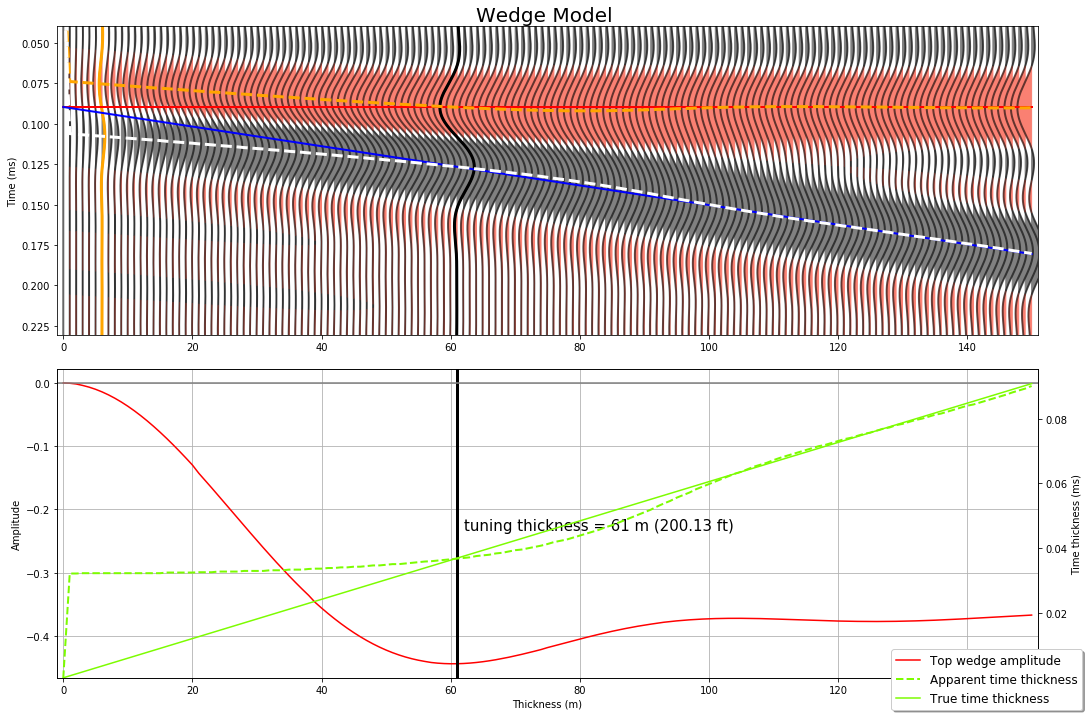

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))

top_loc = int(t_table[0][0]/dt)
gain=6
gs = GridSpec(nrows=2, ncols=1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = ax2.twinx()

for i,s in enumerate(syn.T):
    ax1.plot(s * gain + i, t, color = 'k', alpha=0.6, lw=2)
    ax1.fill_betweenx(t, i, s * gain + i, where = s * gain + i > i, color='grey', interpolate=True)
    ax1.fill_betweenx(t, i, s * gain + i, where = s * gain + i < i, color='salmon', interpolate=True)
ax1.plot(syn[:,tuning_trace] * gain + tuning_trace,t,color='k', lw=3)
ax1.plot(syn[:,6] * gain + 6,t,color='orange', lw=3)
ax1.plot([t[0] for t in t_table], color='r', lw=2)
ax1.plot([t[1] for t in t_table], color='b', lw=2)
ax1.plot(np.multiply(top_pick, dt), lw=3, color='orange', linestyle='--')
ax1.plot(np.multiply(base_pick, dt), lw=3, color='white', linestyle='--')

ax2.plot(syn[top_loc], color='r', label='Top wedge amplitude')
ax2.axvline(tuning_trace, color='k', lw=3)
ax2.axhline(0, color='grey')

ax3.plot(apparent_thickness * dt, lw=2, color='lawngreen', linestyle='--', label='Apparent time thickness')
ax3.plot(np.subtract([t[1] for t in t_table], [t[0] for t in t_table]), color='lawngreen', label='True time thickness')

ax2.text(tuning_trace + 1, 
         ax2.set_ylim()[0] * 0.5,
         f'tuning thickness = {tuning_thickness} m ({tuning_thickness * 3.28084:.2f} ft)',
         size=15)

fig.legend(loc='lower right', facecolor='w', shadow=True, fontsize=12)

ax1.set_xlim(-1,thickness+1)
ax1.set_ylim(y_limits)
ax1.invert_yaxis()
ax3.set_ylim(0)
ax3.set_ylabel('Time thickness (ms)')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.grid()
fig.suptitle('Wedge Model', fontsize=20)

ax1.set_ylabel('Time (ms)', size = 10)

plt.savefig('figures/LeonTarWedgeMeters.png', bbox_inches='tight', dpi=250)

### Tuning affecting AVO

Since the tuning of thin beds affects the amplitude of their reflection, it is clear that thin bed responses will affect the robustness of property estimtations derived from AVO based analyses. i.e. not only will our amplitudes be affected by  

Below is a script which generates a prestack angle gather for a bed thickness defined by the user. 

#### Python script to generate a synthetic angle gather from a 3-layer property model to examine pre-stack tuning effects.

In [39]:
def pre_stacky(vp1=4016.0, vpRes=4219.0, vp3=4255.0, 
               vs1=2123.0, vsRes=2544.0, vs3=2262.0, 
               rho1=2.615, rhoRes=2.479, rho3=2.621, 
               f=25, plot_buff=0.03, res_thickness=19, gain=15, theta_max=40):
    '''
    Generates a pre-stack angle gather to evaluate the affects of tuning in the pre-stack domain
    '''
    
    shape = (1000,)
    dt = 0.0001
    vp = [vp1, vpRes, vp3]
    vs = [vs1, vsRes, vs3]
    rho = [rho1, rhoRes, rho3]
    
    
    w = b.filters.ricker(0.256,dt,f=f)

#     res_thickness = 19
    theta = np.arange(theta_max)
    top_depth = 400
    base_depth = top_depth + res_thickness

    # Create in situ blocked logs ----------------
    shape = (1000,)
    block_vp, block_vs, block_rhob = np.zeros(shape), np.zeros(shape), np.zeros(shape)
    block_vp[:top_depth], block_vs[:top_depth], block_rhob[:top_depth] = vp1, vs1, rho1
    block_vp[base_depth:], block_vs[base_depth:], block_rhob[base_depth:] = vp3, vs3, rho3
    block_vp[top_depth:base_depth] = vpRes
    block_vs[top_depth:base_depth] = vsRes
    block_rhob[top_depth:base_depth] = rhoRes


    depth_curves = [block_vp, block_vs, block_rhob]
#     curves=['Vp', 'Vs', 'rho']
    dz = 1
    twt_curves = [b.transform.depth_to_time(d, depth_curves[0], dz, dt, return_t=True) for d in depth_curves]
    mdl_interfaces = calc_twt([top_depth, base_depth - (res_thickness/2)],vp)
    top_time = np.ones(theta.max() + 1) * mdl_interfaces[0] * 2
    base_time = np.ones(theta.max() + 1) * mdl_interfaces[1] * 2

    rc_curves = b.reflection.reflectivity(twt_curves[0][0], twt_curves[1][0], twt_curves[2][0],theta=theta)
    true_r_top = np.real(b.reflection.reflectivity(vp[:2], vs[:2], rho[:2], theta=theta))
    true_r_base = np.real(b.reflection.reflectivity(vp[1:], vs[1:], rho[1:], theta=theta))

    syn = np.apply_along_axis(lambda x: np.convolve(w,x,mode='same'), axis=1, arr=rc_curves)
    i_zTop, g_zTop = b.reflection.shuey(vp1, vs1, rho1, vpRes, vsRes, rhoRes,return_gradient=True)#igc(vp[:2], vs[:2], rho[:2], 30)
    i_zBase, g_zBase = b.reflection.shuey(vpRes, vsRes, rhoRes, vp3, vs3, rho3,return_gradient=True)#igc(vp[1:], vs[1:], rho[1:], 30)
    
    
    top_convolved_rc = np.real(syn[:,np.argmax(twt_curves[0][0]!=vp[0])])
    base_convolved_rc = np.real(syn[:,np.argmax(twt_curves[0][0]==vp[2])])
    
    sinsqtheta = np.sin(np.radians(np.arange(30)))**2
    A = np.vstack([sinsqtheta, np.ones(len(sinsqtheta))]).T
    m_top,c_top = np.linalg.lstsq(A, top_convolved_rc[:30], rcond=None)[0]
    m_base,c_base = np.linalg.lstsq(A, base_convolved_rc[:30], rcond=None)[0]
    
    fig = plt.figure(constrained_layout=True, figsize=(15,19))

    gs = GridSpec(nrows=6, ncols=6, figure=fig)
    ax1 = fig.add_subplot(gs[:2, 0])
    ax2 = fig.add_subplot(gs[:2, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[:2, 2], sharey=ax1)
    ax4 = fig.add_subplot(gs[:2, 3:], sharey=ax1)
    ax5 = fig.add_subplot(gs[2:4, :3])
    ax6 = fig.add_subplot(gs[2:4, 3:])
    ax7 = fig.add_subplot(gs[4:, :3])

    # define some useful lists for plotting
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    titles = [r'$V_{p} \ \frac{m}{s}$', r'$V_{s} \ \frac{m}{s}$', r'$Density \ \frac{g}{c^{3}}$', 
              f'Synthetic Angle Gather \n Layer Thickness = {res_thickness} m \n Wavelet freq. = {f} Hz',
              'Top Reflectivity', 'Base Reflectivity', 'Intercept-Gradient Plot']
    twt_basis = twt_curves[0][1][:-1]

    # Upper plot (curves and pre-stack synthetic)
    for i,ax in enumerate(axes[:3]):
        ax.plot(twt_curves[i][0], twt_curves[0][1], lw=2, c='k')
        ax.axhline(top_time[0], c='b', lw=2)
        ax.axhline(base_time[0], c='r', lw=2)

    for i in range(theta.max()):
        ax4.plot(np.real(syn[i]) * gain + i, twt_basis, color='k')
        ax4.fill_betweenx(twt_basis, np.real(syn[i]) * gain + i, i, 
                          where=np.real(syn[i]) * gain + i > i, color = 'grey', interpolate=True)
        ax4.plot(np.real(syn[i]) * gain + i, twt_basis, color='k')
        ax4.fill_betweenx(twt_basis, np.real(syn[i]) * gain + i, i, 
                          where=np.real(syn[i]) * gain + i < i, color = 'salmon', interpolate=True)
    ax4.plot(top_time, c='b', lw=2)
    ax4.plot(base_time, c='r', lw=2)

    ax5.plot(true_r_top, lw=2, c='b', label='Zoeppritz')
    ax5.plot(np.real(syn[:,np.argmax(twt_curves[0][0]!=vp[0])]), lw=2, c='b', ls='--', label='Convolved')
    ax6.plot(true_r_base, lw=2, c='r', label='Zoeppritz')
    ax6.plot(np.real(syn[:,np.argmax(twt_curves[0][0]==vp[2])]), lw=2, c='r', ls='--', label='Convolved')

    # Intercept gradient plots
    s = 120
    ax7.scatter(i_zTop, g_zTop, color='b', label='Zoeppritz top', s=s)
    ax7.scatter(c_top, m_top, edgecolors='b', label='Convolved top', s=s,facecolors='none')
    ax7.scatter(i_zBase, g_zBase, color='r', label='Zoeppritz base', s=s)
    ax7.scatter(c_base, m_base, edgecolors='r', label='Convolved base', s=s, facecolors='none')
    
    # add zero reflectivity lines to bottom plots
    for ax in (ax5, ax6):
        ax.set_xlabel('Angle of Incidence', size=13)
        ax.set_ylabel('Reflectivity', size=13)
    ax7.set_ylabel('Gradient', size=13)
    ax7.set_xlabel('Intercept', size=13)

    # labels, titles, style, and limits
    for i,ax in enumerate(axes):
        ax.set_title(titles[i], size=15)
    ax1.set_ylabel('TWT (s)', size=13)
    for ax in (ax1,ax2,ax3,ax5,ax6,ax7):
        ax.grid(alpha=0.6)
    for ax in (ax5, ax6, ax7):
        ax.legend(loc='lower left', fontsize=12)
    for ax in (ax5, ax6, ax7):
        ax.axhline(0, c='k',alpha=0.6, lw=2)
    ax7.axvline(0, c='k', alpha=0.6, lw=2)
    ax4.set_xlim(-1, len(syn))
    ax7.set_ylim(-1, 1)
    ax7.set_xlim(-1, 1)
    ax1.set_ylim(top_time[0] - plot_buff,base_time[0] + plot_buff)
    ax1.invert_yaxis()

In [40]:
interact_manual(pre_stacky, continuous_update=False,
                gain=IntSlider(max=50, min=1, value=15),
                vp1=FloatSlider(max=4500., min=1500., value=4016.0),
                vpRes=FloatSlider(max=4500., min=1500., value=4219.0),
                vp3=FloatSlider(max=4500., min=1500., value=4255.0),
                vs1=FloatSlider(max=3000., min=400., value=2123.0),
                vsRes=FloatSlider(max=3000., min=400., value=2544.0),
                vs3=FloatSlider(max=3000., min=400., value=2262.0),
                rho1=FloatSlider(max=2.8, min=1.65, value=2.615),
                rhoRes=FloatSlider(max=2.8, min=1.65, value=2.479),
                rho3=FloatSlider(max=2.8, min=1.65, value=2.621),
                res_thickness=IntSlider(max=150, min=1, value=19),
                f=IntSlider(max=125, min=4, value=31),
                plot_buff=FloatSlider(max=0.1, min=0.01, value=0.03, step=0.01),
                theta_max=IntSlider(max=89, min=5, value=40)
               )

interactive(children=(FloatSlider(value=4016.0, description='vp1', max=4500.0, min=1500.0), FloatSlider(value=…

<function __main__.pre_stacky>

### How does the phenomenon of tuning affect our intercept and gradient plot? 

Since tuning interference will affect the amplitudes of our reflections at all angles, it will also affect our interpreted AVO repsonses. The final plot in the above figure shows how tuning has affected the least squares solution to the intercept and gradient.